In [ ]:
# Install libraries

import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import Tuple, Dict
from collections import defaultdict
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


In [2]:
# Setting up train, test folders paths

train_dataset = "./Intel_Image_Classification/train_segment/originals"
test_dataset  = "./Intel_Image_Classification/test_segment"

In [3]:
# Figguring out (height, width, imager/class, format) of images from either training or testing sets

def get_info_from_data_set(path: str) -> Tuple[int, int, Dict[str, int], Dict[str, int]]:
    heights = []
    widths  = []
    formats = defaultdict()
    images_per_class = dict()

    for image_class in os.listdir(path):
        image_class_dir = os.path.join(path, image_class)
        class_images    = os.listdir(image_class_dir)

        images_per_class[image_class] = len(class_images)

        for image in class_images:
            image_path     = os.path.join(image_class_dir, image)
            image_as_array = np.array(Image.open(image_path))
            
            h, w, c = image_as_array.shape

            heights.append(h)
            widths.append(w) 

            image_name, image_extension = os.path.splitext(image_path)

            if image_extension not in formats.keys():
                formats[image_extension] = 0
            else:
                formats[image_extension] += 1
            

    average_height = sum(heights) / len(heights)
    average_wifth  = sum(widths) / len(widths)

    return (round(average_height), round(average_wifth), images_per_class, formats)

In [4]:
(average_img_h, average_img_w, images_per_class, formats) = get_info_from_data_set(train_dataset)
print(f'average_height:   {average_img_h}')
print(f'average_width:    {average_img_w}')
print(f'formats:          {formats}')
print(f'images_per_class: {images_per_class}')

average_height:   150
average_width:    150
formats:          defaultdict(None, {'.jpg': 14033})
images_per_class: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


In [5]:
# Creating training, testing datasets from the local dir
# Creating an iterator over random batches (DataLoader) 

# Set of transforms to be aplied
transform = v2.Compose([
    v2.ToImage(),       
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),              
    v2.Resize(size=(round(average_img_h), round(average_img_w)))  
])

# Creating train, test sets from folder in root path
train_set = torchvision.datasets.ImageFolder(root=train_dataset, transform=transform)
test_set  = torchvision.datasets.ImageFolder(root=test_dataset,  transform=transform)

# Creating iterable dataloders
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=16,  shuffle=True)

print(f'batches_in_train_dataloader: {len(train_dataloader)}')
print(f'batches_in_test_dataloader:  {len(test_dataloader)}')

batches_in_train_dataloader: 878
batches_in_test_dataloader:  188


In [6]:
# Getting numeric, alpabetical labels from the dataset

labels_numbers_to_strings = {val: key for key, val in train_dataloader.dataset.class_to_idx.items()}
labels_strings_to_numbers = train_dataloader.dataset.class_to_idx

print(f'labels_numbers_to_strings: {labels_numbers_to_strings}')
print(f'labels_strings_to_numbers: {labels_strings_to_numbers}')

labels_numbers_to_strings: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
labels_strings_to_numbers: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


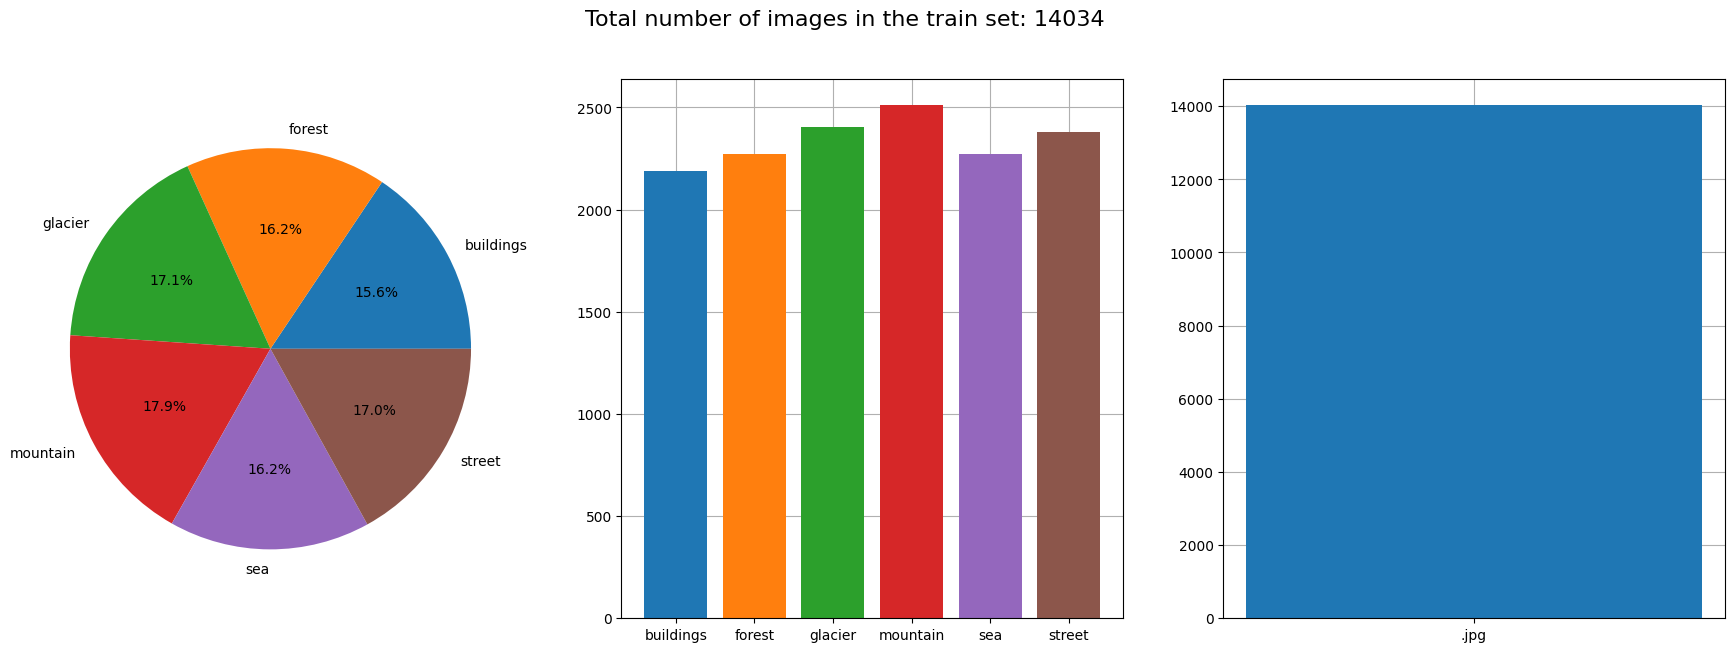

In [7]:
# Creating plots (1 row of 3 plots)
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

# Creating a pie
wedges, texts, autotext = ax[0].pie(
    x      = list(images_per_class.values()), 
    labels = list(images_per_class.keys()) ,  
    autopct= lambda pct: f'{pct:.1f}%'
    ) 

# Remembering pie colors to use on the next plot
pie_colors = [wedge.get_facecolor() for wedge in wedges]

# Creating a bar plot for image/class distribution
ax[1].bar(
    images_per_class.keys(), 
    images_per_class.values(), 
    color  = pie_colors,
    zorder = 2
    )   
ax[1].grid()

# Creating a bar plot for img type distribution
ax[2].bar(
    formats.keys(), 
    formats.values(), 
    zorder = 2
    ) 
ax[2].grid()

fig.suptitle(f'Total number of images in the train set: {sum(images_per_class.values())}', fontsize=16)

plt.show()

In [8]:
# Used for displaying multiple images on a single pyplot
def print_images(images_as_vectors, labels_strings=None, labels_numeric=None):
    if labels_strings != None and labels_numeric != None:
        raise ValueError('Optional labels_strings, labels_numeric cannot both be set, use 1 of them')   
    
    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_strings supposed to have the same size")

    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_numeric supposed to have the same size")
    
    # Create a single plot for multiple images (one subplot per image)
    # The number of columns in the plot is determined by the number of images to display
    fig, axes = plt.subplots(ncols=len(images_as_vectors), figsize=(20, 20))

    # Setting up labels for images
    labels = [''] * len(images_as_vectors)
    if labels_strings != None:
        labels = labels_strings
    elif labels_numeric != None:
        labels = [labels_numbers_to_strings[int(i)] for i in labels_numeric]

    # Plotting images
    for index, image_as_vector in enumerate(images_as_vectors):

        # image_as_vector is expected to have shape of [chanels, h, w], since it is from datLoader
        # Pyplot expects images to have rgb chanels in the last dimention, so transpose
        image_as_vector = np.transpose(image_as_vector, (1, 2, 0))

        # If 1 image is passed, creating subplots of length 1 will create a normal subplot
        # It wont be subscriptable, so it [] is used on it, i will result in a crash
        # So need a separate if
        if len(images_as_vectors) == 1:
            fig.set_size_inches(3, 3)

            # Plotting the image
            axes.imshow(image_as_vector)
            axes.title.set_text(labels[index])
            axes.title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes.set_xticks([])
            axes.set_yticks([])
        else:
            # Plotting the image
            axes[index].imshow(image_as_vector)
            axes[index].title.set_text(labels[index])
            axes[index].title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes[index].set_xticks([])
            axes[index].set_yticks([])
    
    plt.show()

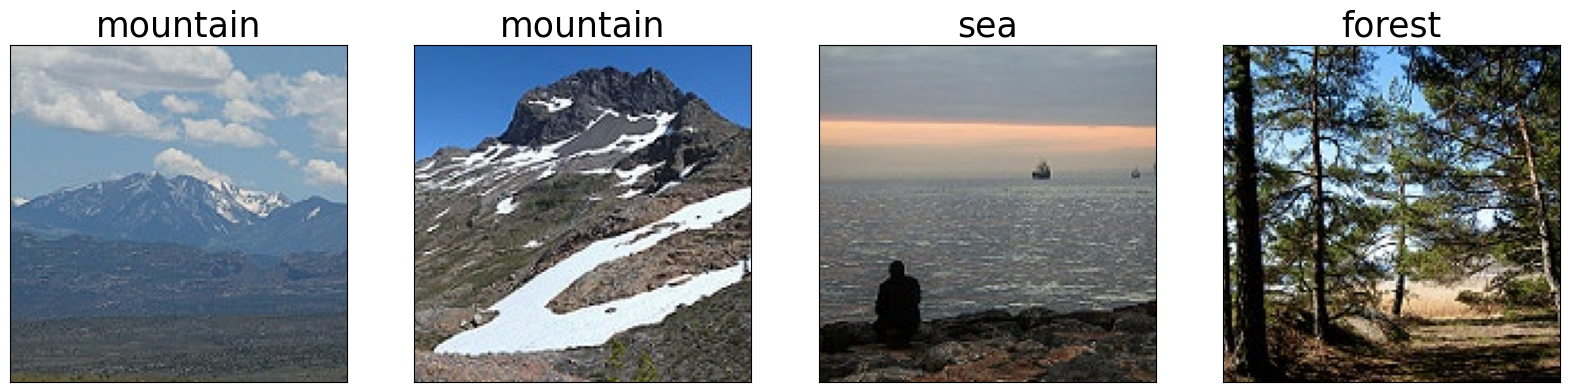

In [9]:
# Displaying some of the augmented images

first_batch = next(iter(train_dataloader))
first_batch_images         = first_batch[0]
first_batch_labels_numeric = first_batch[1]

print_images(first_batch_images[:4], labels_numeric=first_batch_labels_numeric)

In [10]:
# ======================================================================================================================================================================================
# ======================================================================================================================================================================================
# ======================================================================================================================================================================================

In [11]:
# == Model Description =========================================================================================================

# self.conv1  = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#   Transforming 3-channeled image into 6 conv maps, therefor into 6 chanels. Each convolution window if 5x5
#   In other words:
#       applying 6 filters on a rgb image

# self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
#   Received 6 concolutions form conv1, apllying 2x2 pooling on them
#   In the end have 6 convolutions but kinda lossly compressed (pooled)

# self.conv2  = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#   Same as conv1, but 6 layers in after conv1 and pool1, and 16 out.


# self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
#   Same as pool1, but now working on 16 layers

# self.fc1    = nn.Linear(in_features=16*34*34, out_features=120)
#   Fully connected layer
#   We receive a vector of 16 * 34 * 34, why: 
#       1. 16 is the number of layes 
#       2. 34 x 34 is the size of a single conv to whitch eatch image was transofrmed after conv1, pool1 ...
#       3. 16 is the number of those convs for each image. So 1 iamge, if displayed as a vector, would have 16 * 34 * 34 dims
 

# self.fc2    = nn.Linear(in_features=120, out_features=84)
# self.fc3    = nn.Linear(in_features=84, out_features=len(labels_numbers_to_strings))
#   These 2 are just reducing the vectors, until a vector if shape len(labels_numbers_to_strings) is reached.
#   That vector represent end values for each class 

# ==============================================================================================================================

# def forward(self, inputs):
#     inputs is a tensor of shape (batch_size, c, h, w)

#     inputs = self.pool1(F.relu(self.conv1(inputs)))   <- first layer
#     inputs = self.pool2(F.relu(self.conv2(inputs)))   <- second layer

#     inputs = torch.flatten(inputs, 1) 
#       Since inputs is a batch, we only flatten each image representation of newly created convlotions 

#     inputs = F.relu(self.fc1(inputs))     <- fullt connected 1
#     inputs = F.relu(self.fc2(inputs))     <- fullt connected 2
#     inputs = self.fc3(inputs)             <- fullt connected 3
#     return inputs

In [12]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1  = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2  = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1    = nn.Linear(in_features=16*34*34, out_features=120)
        self.fc2    = nn.Linear(in_features=120, out_features=84)
        self.fc3    = nn.Linear(in_features=84, out_features=len(labels_numbers_to_strings))

    def forward(self, inputs):
        inputs = self.pool1(F.relu(self.conv1(inputs)))
        inputs = self.pool2(F.relu(self.conv2(inputs)))
        inputs = torch.flatten(inputs, 1) # flatten all dimensions except batch
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        inputs = self.fc3(inputs)
        return inputs


In [37]:
# Registering a gpu 

print(torch.cuda.get_device_properties())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Ti', major=8, minor=6, total_memory=8191MB, multi_processor_count=38, uuid=d5fb8565-b5cf-a304-9b09-1ee3544b0753, L2_cache_size=3MB)
cuda:0


In [38]:
# Creating a model and moving onto a gpu

model = CNN_Model().to(device)
print(model)

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
# optimizer     = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

In [40]:
def test_model(dataloader: DataLoader) -> Tuple[Dict[str, int], Dict[str, int]]:
    total_loss      = 0
    total_precision = 0
    total_recall    = 0
    total_f1        = 0

    for inputs, labels in dataloader:

        # Moving tensors onto a gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Getiing a prediction
        batch_predictions = model(inputs)

        loss = loss_function(batch_predictions, labels)
        total_loss += loss.item()

        # Getting a predicted class for each input
        max_values, max_indices = torch.max(batch_predictions, 1)

        total_precision += np.average(precision_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        total_recall    += np.average(recall_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        total_f1        += np.average(f1_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
    
    total_loss      /= len(dataloader)   
    total_precision /= len(dataloader)
    total_recall    /= len(dataloader)
    total_f1        /= len(dataloader)

    return (total_loss, total_precision, total_recall, total_f1)

In [41]:
# Training the model

n_epochs = 30

# Using these for logging
epoch_losses             = []
epoch_precision          = []
epoch_recall             = []  
epoch_f1                 = []

epoch_losses_on_test     = []
epoch_precisions_on_test = []
epoch_recalls_on_test    = []
epoch_f1_on_test         = []

epoch_start_time    = 0     
model_training_time = 0    

print("[{:^10} {:^10} {:^10} {:^10} {:^10} {:^10} {:^15} {:^15} {:^10} {:^12} {:^12}]".format(
        "Epoch", "Batch_Loss", "Recall", "Precision", "F1", "Test_Loss", "Test_Precision", "Test_Recall", "Test_F1", "Batch_Time", "Total_Time"))

for epoch in range(n_epochs):
    epoch_start_time = time.time()
    
    # These to track performance during each epoch
    loss      = 0.0
    precision = 0.0
    recall    = 0.0
    f1        = 0.0

    for inputs, labels in train_dataloader:
        # Moving tensors onto a gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients (Reson for it: https://medium.com/@lazyprogrammerofficial/in-pytorch-why-do-we-need-to-call-optimizer-zero-grad-8e19fdc1ad2f#:~:text=zero_grad()%20method%20is%20used,respect%20to%20the%20model%20parameters.)
        optimizer.zero_grad()

        # Outputs -> Tensor.shape = (batch_size, number_of_possible_classes)
        outputs = model(inputs)

        # Loss, Backpropogation, Optimization
        cur_loss = loss_function(outputs, labels)
        cur_loss.backward()
        optimizer.step()

        # Storing stuff for plotting
        loss += cur_loss.item()
        
        # Getting labels for predicted ouputs
        max_values, max_indices = torch.max(outputs, 1)

        precision += np.average(precision_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        recall    += np.average(recall_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        f1        += np.average(f1_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))

    # Averaging oven number of batches in epoch
    loss      /= len(train_dataloader)
    precision /= len(train_dataloader)
    recall    /= len(train_dataloader)
    f1        /= len(train_dataloader)

    # Storing last epoch's results
    epoch_losses.append(loss)
    epoch_precision.append(precision)
    epoch_recall.append(recall)
    epoch_f1.append(f1)

    # Testing current state of the model based on testing data
    (test_loss, test_precision, test_recall, test_f1) = test_model(test_dataloader)
    epoch_losses_on_test.append(test_loss)
    epoch_precisions_on_test.append(test_precision)
    epoch_recalls_on_test.append(test_recall)
    epoch_f1_on_test.append(test_f1)

    # Logging time spent on the previous epoch
    epoch_time_spent_min = (time.time() - epoch_start_time) / 60
    model_training_time  += epoch_time_spent_min

    print("[{:^10} {:^10.4f} {:^10.4f} {:^10.4f} {:^10.4f} {:^10.4f} {:^15.4f} {:^15.4f} {:^10.4f} {:^12} {:^12}]".format(
        f"{epoch + 1}/{n_epochs}", loss, recall, precision, f1, test_loss, test_precision, test_recall, test_f1,
        f"{epoch_time_spent_min:.1f} min", f"{model_training_time:.1f} min"))
    
print('Done Training')

[  Epoch    Batch_Loss   Recall   Precision      F1     Test_Loss  Test_Precision    Test_Recall    Test_F1    Batch_Time   Total_Time ]
[   1/30      1.0291     0.5744     0.5637     0.5294     0.8682       0.6571          0.6584        0.6219     0.3 min      0.3 min   ]
[   2/30      0.7568     0.7008     0.6997     0.6650     0.8960       0.6755          0.6511        0.6284     0.3 min      0.6 min   ]
[   3/30      0.6409     0.7453     0.7449     0.7157     0.7398       0.7075          0.6991        0.6639     0.3 min      0.8 min   ]
[   4/30      0.5641     0.7750     0.7792     0.7501     0.6943       0.7426          0.7395        0.7106     0.3 min      1.1 min   ]
[   5/30      0.4973     0.8090     0.8121     0.7850     0.7881       0.6888          0.6950        0.6600     0.3 min      1.4 min   ]
[   6/30      0.4437     0.8279     0.8280     0.8038     0.7287       0.7217          0.7225        0.6873     0.3 min      1.7 min   ]
[   7/30      0.3779     0.8489     0.848

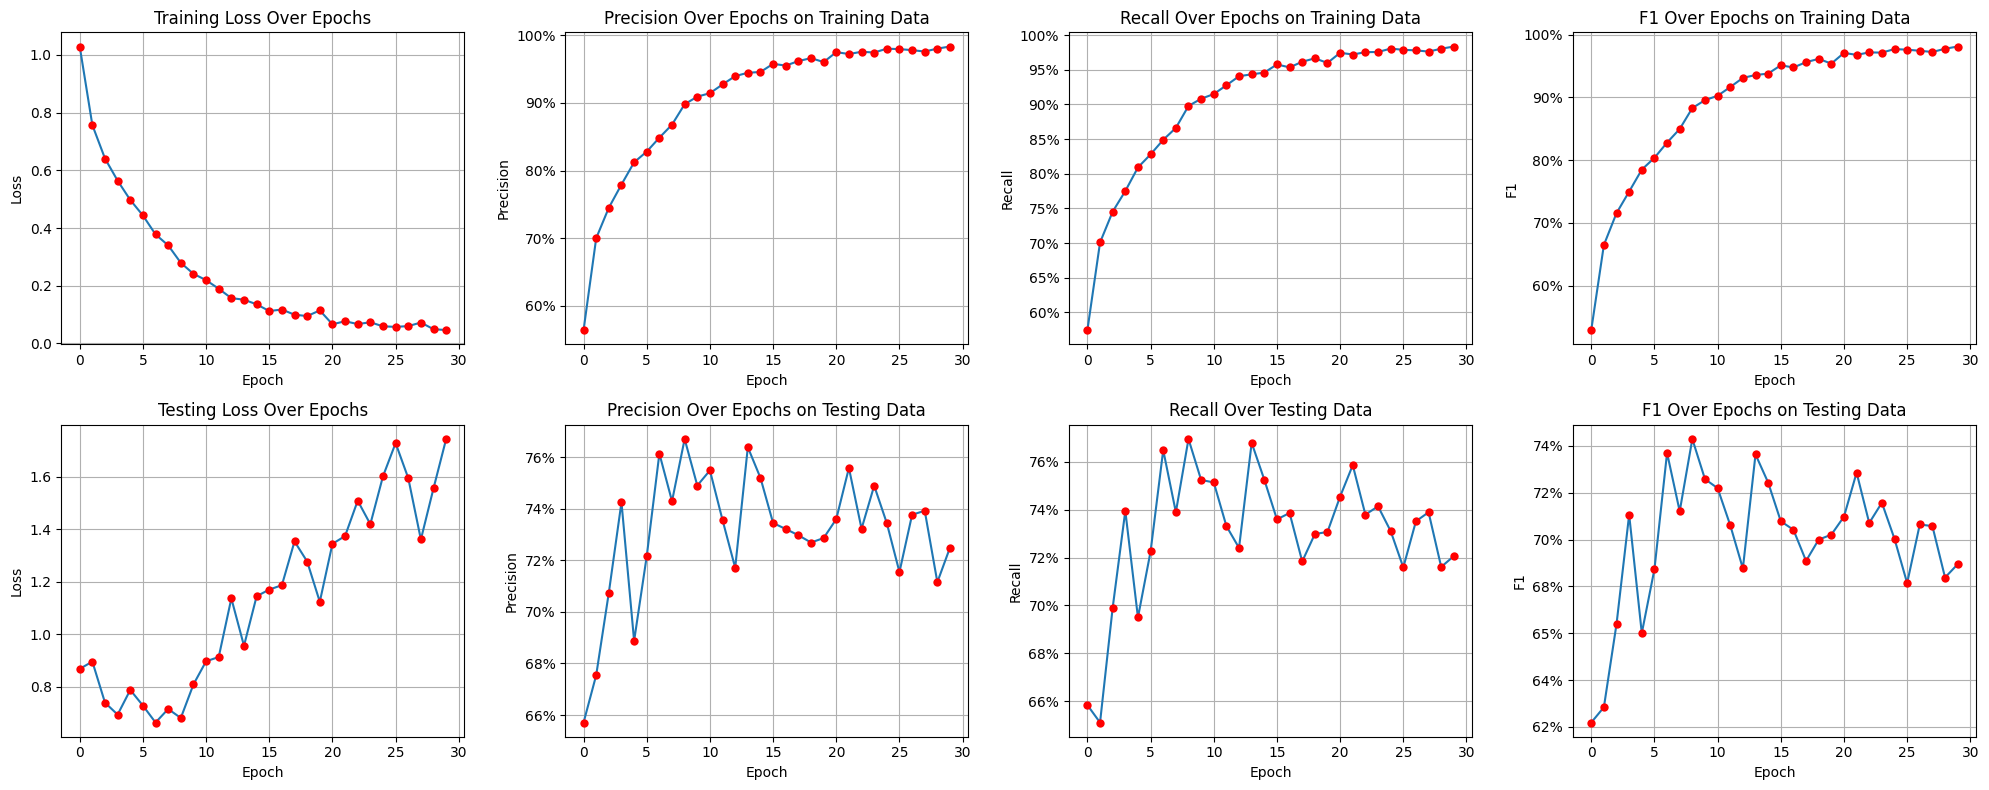

In [44]:
# Creating 8 subplots (2 rows of 4)
fig, ax = plt.subplots(2, 4, figsize=(20, 8)) 

# Plotting the first graph (Training Loss)
ax[0][0].plot(range(n_epochs), epoch_losses, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][0].set_title("Training Loss Over Epochs")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Loss")
ax[0][0].grid()

# Plotting the second graph (Training Preciison)
ax[0][1].plot(range(n_epochs), epoch_precision, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][1].set_title("Precision Over Epochs on Training Data")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Precision")
ax[0][1].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[0][1].grid()

# Protting the third graph (Training Recall)
ax[0][2].plot(range(n_epochs), epoch_recall, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][2].set_title("Recall Over Epochs on Training Data")
ax[0][2].set_xlabel("Epoch")
ax[0][2].set_ylabel("Recall")
ax[0][2].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[0][2].grid()

# Protting the fourth graph (Training F1)
ax[0][3].plot(range(n_epochs), epoch_f1, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][3].set_title("F1 Over Epochs on Training Data")
ax[0][3].set_xlabel("Epoch")
ax[0][3].set_ylabel("F1")
ax[0][3].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[0][3].grid()

# ==============================================================================================================

# Plotting the first graph (Testing Loss)
ax[1][0].plot(range(n_epochs), epoch_losses_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][0].set_title("Testing Loss Over Epochs")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Loss")
ax[1][0].grid()

# Plotting the second graph (Training Preciison)
ax[1][1].plot(range(n_epochs), epoch_precisions_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][1].set_title("Precision Over Epochs on Testing Data")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Precision")
ax[1][1].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[1][1].grid()

# Protting the third graph (Testing Recall)
ax[1][2].plot(range(n_epochs), epoch_recalls_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][2].set_title("Recall Over Testing Data")
ax[1][2].set_xlabel("Epoch")
ax[1][2].set_ylabel("Recall")
ax[1][2].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[1][2].grid()

# Protting the fourth graph (Testing F1)
ax[1][3].plot(range(n_epochs), epoch_f1_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][3].set_title("F1 Over Epochs on Testing Data")
ax[1][3].set_xlabel("Epoch")
ax[1][3].set_ylabel("F1")
ax[1][3].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[1][3].grid()

# Adjusting layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

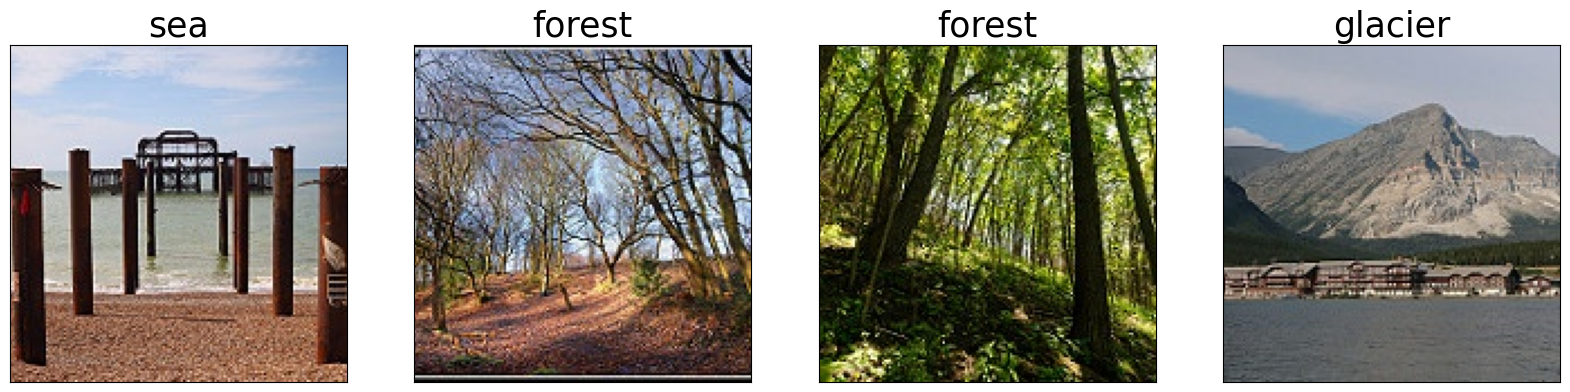

In [45]:
# Visualising a couple of images from the testing set

testing_batch = next(iter(test_dataloader))

testing_batch_images = testing_batch[0]
testing_batch_labels = testing_batch[1]

print_images(testing_batch_images[:4], labels_numeric=testing_batch_labels[:4])

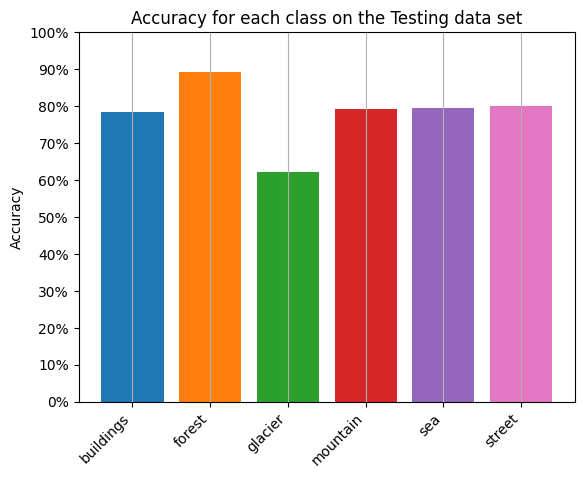

In [ ]:
# TODO: Need this to work again

# fig, ax = plt.subplots()
# classes   = labels_strings_to_numbers.keys()

# # Calculating accuracy for each class
# each_class_accuracy = []
# for i in range(len(classes)):
#     class_i_accuracy = (each_class_correct_predictions[i] / each_class_occurance[i])
#     each_class_accuracy.append(class_i_accuracy)

# colors = [
#     "#1f77b4",  # Blue
#     "#ff7f0e",  # Orange
#     "#2ca02c",  # Green
#     "#d62728",  # Red
#     "#9467bd",  # Purple
#     "#e377c2",  # Pink   
# ]

# # Plotting
# ax.bar(classes, each_class_accuracy, color=colors)
# ax.set_ylabel('Accuracy')
# ax.set_title(f'Accuracy for each class on the {"Testing data set"}')
# ax.set_ylim(0, 1)
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x * 100)}%')
# ax.grid(axis='x')

# plt.xticks(rotation=45, ha='right')
# plt.show()

In [46]:
# Manually testing on a random pictures from the training set

def test_on_a_random_picture(model: CNN_Model, dataloader: DataLoader):
    # Getting a random image
    random_test_batch = next(iter(dataloader))
    random_test_image   = random_test_batch[0][0]

    # Getting a string label for a random image from a numeric stored inside the batch
    random_test_image_label_numeric = random_test_batch[1][0].item()
    random_test_image_label_string  = labels_numbers_to_strings[random_test_image_label_numeric]

    # Image is of shape (3, 150, 150), since model takes in batched of shape (batch_size, 3, 150, 150)
    # we need to make it at least (1, 3, 150, 150), unsqueeze(0) does that
    prediction_vector = model(random_test_image.unsqueeze(0).to(device))
    prediction_max_value, prediction_index = torch.max(prediction_vector, 1)
    predicted_class   = labels_numbers_to_strings[prediction_index.item()]
    
    print(f'Predicted class: {predicted_class}')
    print(f'Actual class:    {random_test_image_label_string}')
    print_images([random_test_image], [predicted_class])
   

Predicted class: sea
Actual class:    sea


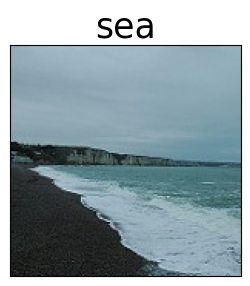

In [51]:
test_on_a_random_picture(model, test_dataloader)

In [52]:
# TODO: maybe add recall, dont know if i need to, seems like accurasy is the most important thing for this type of classification

In [56]:
torch.save(model, 'model.pth')

In [54]:
model = torch.load('model.pth', weights_only=False)

In [55]:
model

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)